In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig, TaskType

In [2]:
df = pd.read_csv("./low_confidence_samples/big_data.csv")
df

,Unnamed: 0,text,label,preprocess_text
0,6,I sure would like to see a resurrection of a u...,2,sure like resurrection date seahunt series tec...
1,7,"This show was an amazing, fresh & innovative i...",0,amazing fresh innovative idea 70 air 7 8 year ...
2,14,This a fantastic movie of three prisoners who ...,2,fantastic movie prisoner famous actor george c...
3,32,My first exposure to the Templarios & not a go...,0,exposure templarios good excited find title of...
4,43,"I had heard good things about ""States of Grace...",0,hear good thing states grace come open mind th...
...,...,...,...,...
62495,678949,Don't. Just don't. Every horrible thing people...,1,horrible thing people say 100 true read review...
62496,678966,As you walk in the order Kiosks are too close ...,1,walk order kiosk close door walk right people ...
62497,678981,This used be Cathy House. . Now The Jade. . It...,2,cathy house jade improvement dim sum way well ...
62498,679006,"Long line, inefficient staff. Maybe my expecta...",1,long line inefficient staff maybe expectation ...


In [ ]:
df['label'].unique()
df['label'].value_counts()

array([2, 0, 1])

In [4]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True)

# Ensure text data is a list of strings and drop missing values
df_train['text'] = df_train['preprocess_text'].astype(str)
df_test['text'] = df_test['preprocess_text'].astype(str)

# Ensure text is lowercase
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

In [5]:
df_train

,Unnamed: 0,text,label,preprocess_text
43002,416044,welcome nogales hotdogs hot dog attraction \n\...,2,welcome nogales hotdogs hot dog attraction \n\...
56726,595718,wrong love tj maxx homegoods marshall like lov...,1,wrong love tj maxx homegoods marshall like lov...
6566,41377,funniest movie recent year good characterizati...,2,funniest movie recent year good characterizati...
55029,573098,hard find dj talente punctual quick reply call...,2,hard find dj talente punctual quick reply call...
55201,575571,time clt starve come huge ass parking deck s...,1,time clt starve come huge ass parking deck s...
...,...,...,...,...
52893,543772,4 star 3 story prada store salesperson way nic...,2,4 star 3 story prada store salesperson way nic...
6561,41349,guinea pig series infamous film collection.<br...,2,guinea pig series infamous film collection.<br...
6278,39760,watch dvd version born bad find tense gritty n...,2,watch dvd version born bad find tense gritty n...
23993,183509,tell tire works need new brake rotor total 400...,2,tell tire works need new brake rotor total 400...


In [6]:
df_test

,Unnamed: 0,text,label,preprocess_text
22210,159174,truely well mexican restaurant north scottsdal...,2,truely well mexican restaurant north scottsdal...
48279,482985,ummmm ...... bad burger time hey like salty...,1,ummmm ...... bad burger time hey like salty...
33655,299098,review restaurant \n\nwell wait 40 minute satu...,2,review restaurant \n\nwell wait 40 minute satu...
2087,13241,see movie primarily brooke burke jill meet bri...,0,see movie primarily brooke burke jill meet bri...
56837,597292,recommend go apart poor service food great thi...,1,recommend go apart poor service food great thi...
...,...,...,...,...
57831,610257,usually love place tonight ... sign door sugge...,1,usually love place tonight ... sign door sugge...
3504,22303,anemic comedy drama unhappy seemingly rush aff...,0,anemic comedy drama unhappy seemingly rush aff...
7860,49843,shocked hate rating six seven average case emp...,0,shocked hate rating six seven average case emp...
49808,504416,go colleague fringe society!\n\ni go shop shor...,2,go colleague fringe society!\n\ni go shop shor...


In [7]:
model_name = 'google-bert/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train[['text', 'label']])
test_dataset = Dataset.from_pandas(df_test[['text', 'label']])

# Adding short max length to lower training time
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/43750 [00:00<?, ? examples/s]

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

In [9]:
import torch
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: cuda


In [10]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],  # BERT uses query, key, value in attention
    lora_dropout=0.1,
    bias="all",
    task_type=TaskType.SEQ_CLS
)

training_args = TrainingArguments(
    output_dir="./results/" + model_name,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    # gradient_checkpointing=True,
    num_train_epochs=3,
    dataloader_num_workers=5,
    logging_steps=100,
    optim="adamw_torch",
    # weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
)

model = get_peft_model(model, lora_config)
model = model.to(device)

for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Define a compute metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    accuracy = accuracy_score(p.label_ids, preds)
    return {'accuracy': accuracy}

In [12]:
from transformers import TrainerCallback

class LossAccuracyLogger(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append((state.epoch, logs["loss"]))
            if "eval_accuracy" in logs:
                self.eval_accuracy.append((state.epoch, logs["eval_accuracy"]))


In [13]:
logger_callback = LossAccuracyLogger()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger_callback]
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [14]:
# Train the model
trainer.train()

KeyboardInterrupt: 

In [ ]:
trainer.save_model("./results/" + model_name + "v1")

{'eval_loss': 0.7240390181541443, 'eval_accuracy': 0.5895620246525046, 'eval_runtime': 73.5016, 'eval_samples_per_second': 103.753, 'eval_steps_per_second': 3.252, 'epoch': 3.0}


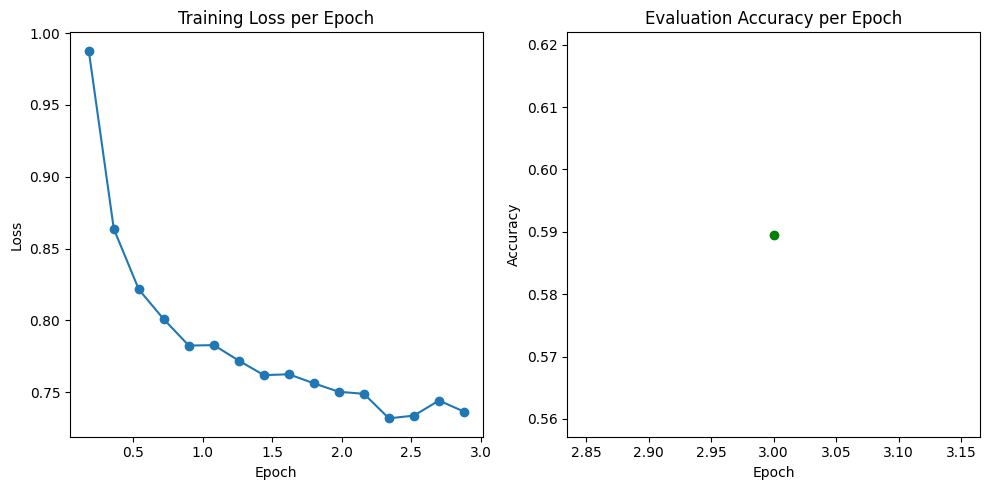

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

import matplotlib.pyplot as plt

# Unpack the epoch and values
train_epochs, train_losses = zip(*logger_callback.train_loss)
eval_epochs, eval_accuracies = zip(*logger_callback.eval_accuracy)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate fine-tuned model on all samples, including non low confidence ones
df_test = pd.read_csv('./data/SA_cleaned.csv')
df_test['text'] = df_test['preprocess_text'].astype(str)
df_test['label'] = df_test['label'].astype(int)
df_test

,Unnamed: 0,text,label,preprocess_text
0,0,reviewer mention watch 1 oz episode hook right...,2,reviewer mention watch 1 oz episode hook right...
1,1,wonderful little production br /><br />the fil...,2,wonderful little production br /><br />the fil...
2,2,think wonderful way spend time hot summer week...,2,think wonderful way spend time hot summer week...
3,3,basically family little boy jake think zombie ...,0,basically family little boy jake think zombie ...
4,4,petter mattei love time money visually stunnin...,2,petter mattei love time money visually stunnin...
...,...,...,...,...
678506,679009,ryan good yelp claim courteous knowledgable he...,2,ryan good yelp claim courteous knowledgable he...
678507,679010,professional \nfriendly\non time affordable!\n...,2,professional \nfriendly\non time affordable!\n...
678508,679011,phone call voicemail message return stupid w...,1,phone call voicemail message return stupid w...
678509,679012,look like good review go head place jason ry...,1,look like good review go head place jason ry...


In [ ]:
test_dataset = Dataset.from_pandas(df_test[['text', 'label']])
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger_callback]
)

results_all = trainer.evaluate()
print(results_all)

Map:   0%|          | 0/678511 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
